In [1]:
%load_ext autoreload
%autoreload 2
%load_ext functionizer

In [2]:
def save_fig(fig, name):
    fig.savefig(rf"C:\Users\wuyua\OneDrive - The University of Western Ontario\Research\crm\paper\figure\{name}.png", bbox_inches="tight")

In [3]:
from solvers import hr_grid_forward_step_size_independent_1d, uw_grid_forward_step_size_independent_1d, pa_forward_step, hr_grid_forward_step_size_dependent_1d, uw_grid_forward_step_size_dependent_1d
import numpy as np
from matplotlib import pyplot as plt
from time import perf_counter
from scipy.stats import norm
from scipy.integrate import trapz
from tqdm.notebook import tqdm
from scipy.stats import binned_statistic
import pandas as pd
from compress import compress
from scipy.interpolate import interp1d

In [124]:
def solubility(T):
    s_a = 8.437e-3 * T**2 - 0.03032 * T + 4.564
    s_b = 7.644e-3 * T**2 - 0.1165 * T + 6.622
    return s_a/1000, s_b/1000

def supersaturation(T, c):
    s_a, s_b = solubility(T)
    return c/s_a-1, c/s_b-1

def nucleation_rate(T, c, v, kbp=np.array([1e6, 1e5]), kbs = np.array([1e6, 1e5])):
    #/s/kg solvent
    b = 2
    
    sc = np.array(supersaturation(T, c))
    
    B = np.zeros((n_forms, ))
    for i, sc_ in enumerate(sc):
        if sc_ > 0:
            B[i] =  (kbp[i] + kbs[i] * v[i]/1e18) * sc_ ** b

    return B

def gd(T, c, kg, kd):
    g = 1
    d = 1
    
    sc = np.array(supersaturation(T, c))
    GD = np.zeros((n_forms, ))
    for i, sc_ in enumerate(sc):
        if sc_ > 0:
            GD[i] =  kg[i] * sc_ ** g
        elif sc_ < 0:
            GD[i] =  kd[i] * (-sc_) ** d
    return GD

density = 1540 * 1e-18 # kg solid/um3 solid
kshape = 0.48

dL = 0.5
L_edges = np.arange(0, 1000, dL)
L_centers = 0.5 * (L_edges[1:] + L_edges[:-1])
n_init = np.zeros_like(L_centers)
T = 45
c_init = solubility(60)[0]
v_init = trapz(n_init * L_centers ** 3, L_centers)
growth_fcn = hr_grid_forward_step_size_independent_1d

t_total = 4000
dt_max = 30
n_forms = 2
kbp=np.array([1e6, 1e5])
kbs = np.array([1e6, 1e5])
dt_factor = 1.0
kg = np.array([0.1, 0.1])
kd = np.array([-2.2, -2.2])

In [125]:
%%functionize hr_smpt_simulation -a dt_max! kbp! kbs! kg! kd! dt_factor! -r ts cs cnts vols --skip --as_dict
ns = [n_init.copy()] * n_forms # #/um/kg solvent
t = 0
pbar = tqdm(total=t_total, desc="HR")
c = c_init
v = np.array([0.,0.])
cs = [c]
ts =[t]
cnts = [(0.,0.)]
vols = [(0., 0.)]
sol = solubility(T)

while t < t_total:
    
    sc = supersaturation(T, c)
    Gs = gd(T, c, kg, kd)
    Bs = nucleation_rate(T, c, v, kbp, kbs)
    
    # compute time step
    dt_G = dL / np.max(np.abs(Gs))
    # extra requirement: should not exceed the transformation line
    if np.prod(sc) < 0:
        # crossing
        dt_conc = np.inf
        with np.errstate(all='ignore'):
            # suppress divide by zero warning
            for i in range(n_forms):
                dt_conc = np.min([(c - sol[i]) / (3*density*kshape*Gs[i]*trapz(L_centers**2*ns[i], L_centers)), dt_conc])
            
    else:
        dt_conc = np.inf
    
    dt = np.min([dt_G, dt_conc]) * dt_factor
    dt = np.min([dt, t_total-t, dt_max])
    
    # Update nucleation
    for i in range(n_forms):
        if Bs[i] != 0:
            ns[i][0] += Bs[i] * dt / dL
    
    # Update growth
    for i in range(n_forms):
        ns[i] = growth_fcn(ns[i], dL, dt, Gs[i])

    
    # Update concentration
    for i in range(n_forms):
        # v: um3 solid / kg solvent
        v_new = trapz(ns[i] * L_centers ** 3, L_centers) * kshape # #/um/kg solvent * um^3 solid * um
        c -= (v_new - v[i]) * density # kg solute / kg solvent
        v[i] = v_new
    
    t += dt
    pbar.update(dt)
    
    ts.append(t)
    cs.append(c)
    cnts.append([trapz(nn, L_centers) for nn in ns])
    vols.append(v.copy())
pbar.close()

In [126]:
%%functionize pa_smpt_simulation -a dt_max! kbp! kbs! kg! kd! dt_factor! -r ts cs cnts vols --skip --as_dict
Ns = [np.array([]).reshape((0, 2))] * n_forms # #/um/kg solvent
t = 0
pbar = tqdm(total=t_total, desc="PA")
c = c_init
v = np.array([0.,0.])
cs = [c]
ts =[t]
cnts = [(0.,0.)]
vols = [(0., 0.)]
sol = solubility(T)

while t < t_total:

    sc = supersaturation(T, c)
    Gs = gd(T, c, kg, kd)
    Bs = nucleation_rate(T, c, v, kbp, kbs)

    # compute time step
    dt_G = dL / np.max(np.abs(Gs))
    # extra requirement: should not exceed the transformation line
    if np.prod(sc) < 0:
        # crossing
        dt_conc = np.inf
        with np.errstate(all='ignore'):
            # suppress divide by zero warning
            for i in range(n_forms):
                dt_conc = np.min([(c - sol[i]) / (3*density*kshape*Gs[i]*(Ns[i][:, 0]**2 * Ns[i][:, 1]).sum()), dt_conc])

    else:
        dt_conc = np.inf

    dt = np.min([dt_G, dt_conc]) * dt_factor
    dt = np.min([dt, t_total-t, dt_max])

    # Update nucleation
    for i in range(n_forms):
        if Bs[i] != 0:
            new_row = np.array([[0, Bs[i] * dt]])
            Ns[i] = np.vstack([Ns[i], new_row])

    # Update growth
    for i in range(n_forms):
        Ns[i] = pa_forward_step(Ns[i], dt, Gs[i])


    # Update concentration
    for i in range(n_forms):
        # v: um3 solid / kg solvent
        N = Ns[i]
        v_new = (N[:, -1] * N[:, 0]**3).sum() * kshape # #/um/kg solvent * um^3 solid * um
        c -= (v_new - v[i]) * density # kg solute / kg solvent
        v[i] = v_new

    t += dt
    pbar.update(dt)

    ts.append(t)
    cs.append(c)
    cnts.append([N[:, -1].sum() for N in Ns])
    vols.append(v.copy())
pbar.close()

In [127]:
hr_results = hr_smpt_simulation()
pa_results = pa_smpt_simulation()

HR:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

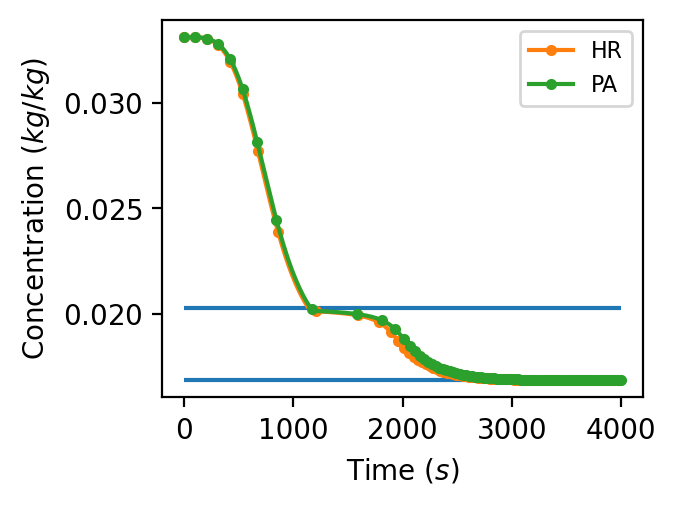

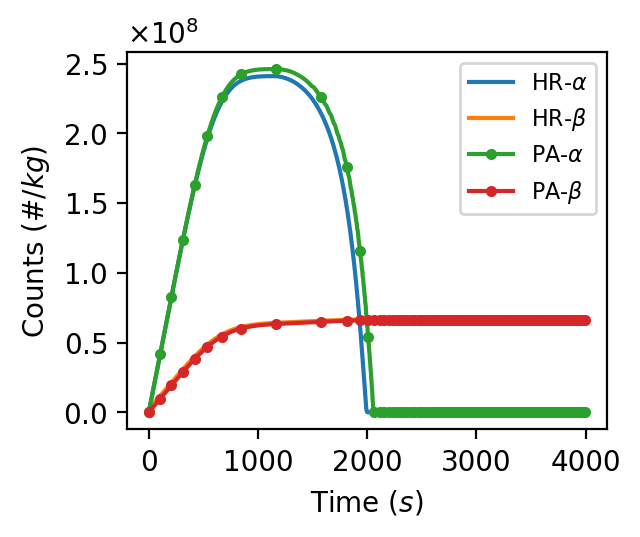

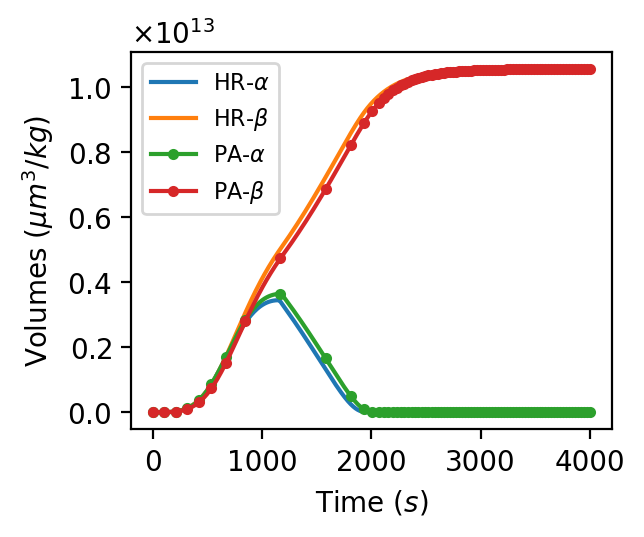

In [128]:
%%functionize plot_concentration -a hr_results pa_results name_suffix='plateau' ylabel=True
fig, ax = plt.subplots(figsize=(3.1, 2.5), dpi=200)
sol = solubility(T)
ax.hlines(sol, 0, t_total)
markevery=20
ax.plot(hr_results["ts"], hr_results["cs"], 'C1.-',label="HR",markevery=markevery)
ax.plot(pa_results["ts"], pa_results["cs"], 'C2.-',label="PA",markevery=markevery)
ax.set_xlabel("Time $(s)$")
if ylabel:
    ax.set_ylabel("Concentration $(kg/kg)$")
ax.ticklabel_format(axis='y', style='scientific', useMathText=True, useOffset=True, scilimits=(-3, 3))
ax.legend(fontsize=8)

save_fig(fig, f"polymorphic_transformation_{name_suffix}_concentration")

fig, ax = plt.subplots(figsize=(3.1, 2.5), dpi=200)
def plot_polymorph_counts(ax, results, name, pattern, markevery=20):
    ts = results["ts"]
    cnts = results["cnts"]
    df = pd.DataFrame(index=ts, data=cnts, columns=["Alpha", "Beta"])
    ax.plot(df["Alpha"], pattern, label=rf"{name}-$\alpha$", markevery=markevery)
    ax.plot(df["Beta"], pattern, label=rf"{name}-$\beta$", markevery=markevery)
    
plot_polymorph_counts(ax, hr_results, "HR", "-")
plot_polymorph_counts(ax, pa_results, "PA", ".-")
ax.set_xlabel("Time $(s)$")
if ylabel:
    ax.set_ylabel("Counts $(\#/kg)$")
ax.ticklabel_format(axis='y', style='scientific', useMathText=True, useOffset=True, scilimits=(-3, 3))
ax.legend(fontsize=8)

save_fig(fig, f"polymorphic_transformation_{name_suffix}_counts")

fig, ax = plt.subplots(figsize=(3.1, 2.5), dpi=200)
def plot_polymorph_vols(ax, results, name, pattern, markevery=20):
    ts = results["ts"]
    vols = results["vols"]
    df = pd.DataFrame(index=ts, data=vols, columns=["Alpha", "Beta"])
    ax.plot(df["Alpha"], pattern, label=rf"{name}-$\alpha$", markevery=markevery)
    ax.plot(df["Beta"], pattern, label=rf"{name}-$\beta$", markevery=markevery)
    
plot_polymorph_vols(ax, hr_results, "HR", "-")
plot_polymorph_vols(ax, pa_results, "PA", ".-")

ax.set_xlabel("Time $(s)$")
if ylabel:
    ax.set_ylabel("Volumes $(\mu m^3/kg)$")
ax.ticklabel_format(axis='y', style='scientific', useMathText=True, useOffset=True, scilimits=(-3, 3))
ax.legend(fontsize=8)

save_fig(fig, f"polymorphic_transformation_{name_suffix}_volumes")


In [129]:
# hr_results_no_plateau = hr_smpt_simulation(kbp=np.array([1e5, 1e6]), kbs=np.array([1e5, 1e6]))
# pa_results_no_plateau = pa_smpt_simulation(kbp=np.array([1e5, 1e6]), kbs=np.array([1e5, 1e6]))
hr_results_no_plateau = hr_smpt_simulation(kd=np.array([-0.2, -0.1]))
pa_results_no_plateau = pa_smpt_simulation(kd=np.array([-0.2, -0.1]))

HR:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

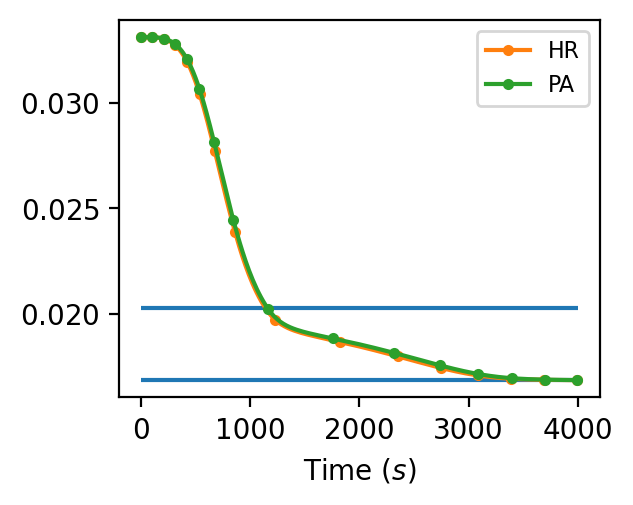

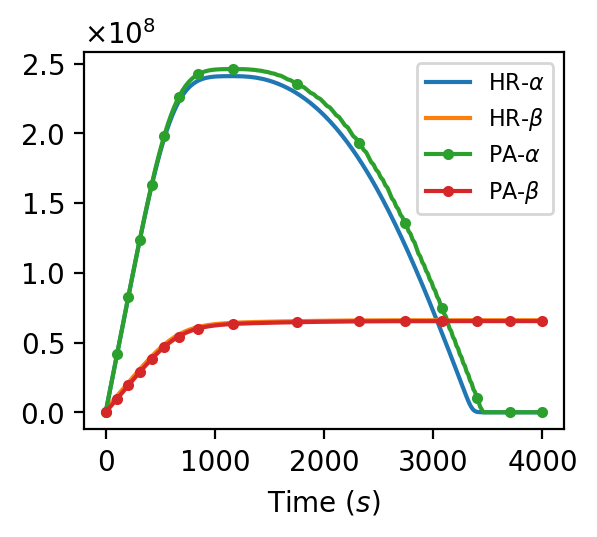

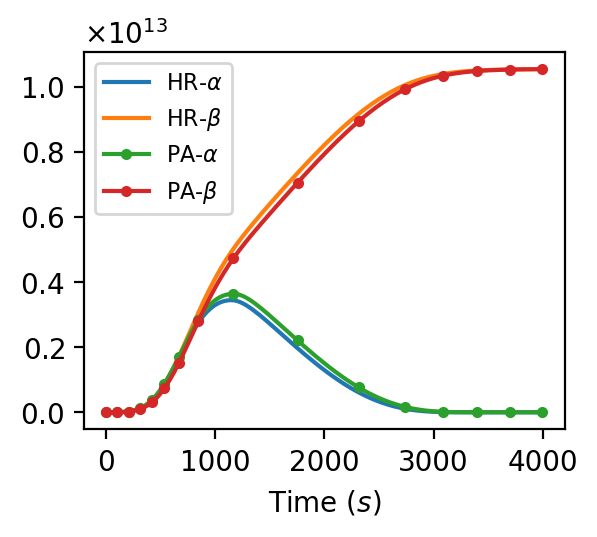

In [130]:
plot_concentration(hr_results_no_plateau, pa_results_no_plateau, "no_plateau", ylabel=False)

# How the time step affect the accuracy performance?

In [131]:
# HR case study
dt_factors_hr = [0.05, 0.1, 0.2, 0.5, 0.8, 1.0]
results_hr = []
for f in tqdm(dt_factors_hr):
    hr_results_cs = hr_smpt_simulation(dt_max=1e9, dt_factor=f)
    results_hr.append(hr_results_cs)
# PA case study
dt_factors_pa = [0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0]
results_pa = []
for f in tqdm(dt_factors_pa):
    pa_results_cs = pa_smpt_simulation(dt_max=1e9, dt_factor=f)
    results_pa.append(pa_results_cs)

  0%|          | 0/6 [00:00<?, ?it/s]

HR:   0%|          | 0/4000 [00:00<?, ?it/s]

HR:   0%|          | 0/4000 [00:00<?, ?it/s]

HR:   0%|          | 0/4000 [00:00<?, ?it/s]

HR:   0%|          | 0/4000 [00:00<?, ?it/s]

HR:   0%|          | 0/4000 [00:00<?, ?it/s]

HR:   0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

PA:   0%|          | 0/4000 [00:00<?, ?it/s]

In [132]:
%%functionize case_study_data  -a results -r q10 q50 q90 --as_dict --skip
evaluate_time_grid = np.linspace(0, t_total, 10)
# ref: smallest time step
r0 = results[0]
i = interp1d(r0["ts"], r0["cs"])
ref_cs = i(evaluate_time_grid)
q50 = []
q10 = []
q90 = []
for r in results[1:]:
    i = interp1d(r["ts"], r["cs"])
    cs = i(evaluate_time_grid)
    data = (ref_cs - cs)/ref_cs
    q50.append(np.quantile(data, 0.5))
    q10.append(np.quantile(data, 0.1))
    q90.append(np.quantile(data, 0.9))
q50 = np.array(q50) * 100
q10 = np.array(q10) * 100
q90 = np.array(q90) * 100

In [133]:
hr_data = case_study_data(results_hr)
pa_data = case_study_data(results_pa)

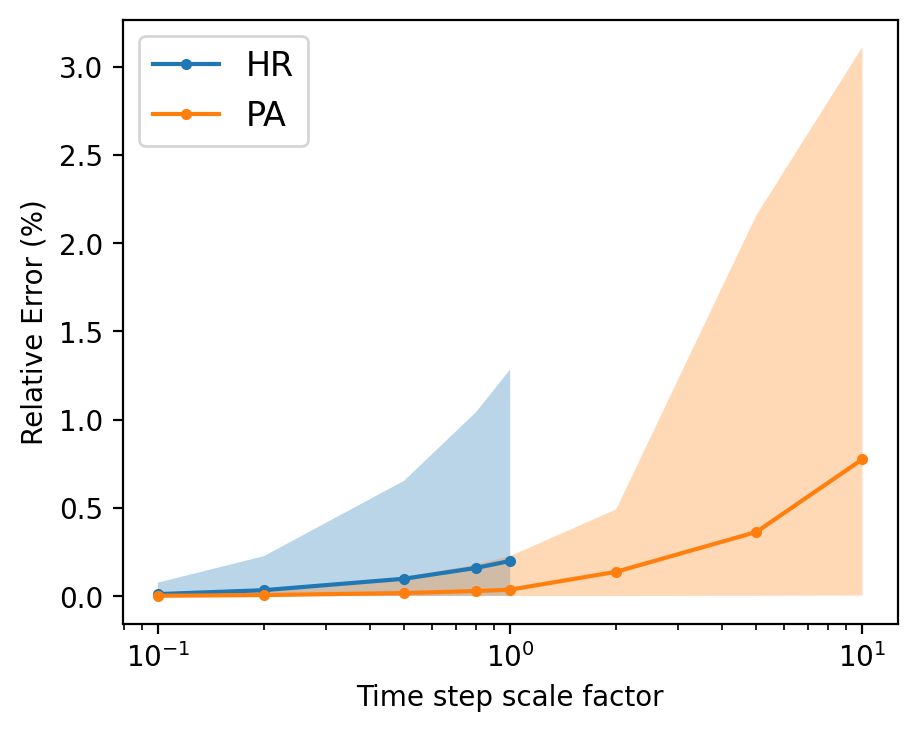

In [134]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=200)
    
ax.plot(dt_factors_hr[1:], hr_data["q50"], '.-', zorder=1.0)
ax.fill_between(dt_factors_hr[1:], hr_data["q10"], hr_data["q90"], alpha=0.3, zorder=0.1)

ax.plot(dt_factors_pa[1:], pa_data["q50"], '.-', zorder=1.0)
ax.fill_between(dt_factors_pa[1:], pa_data["q10"], pa_data["q90"], alpha=0.3, zorder=0.1)

ax.set_xscale("log")
ax.set_ylabel("Relative Error (%)")
ax.set_xlabel("Time step scale factor")
ax.legend(["HR", "PA"], fontsize=12, loc="upper left")

In [135]:
save_fig(fig, f"polymorphic_transformation_time_step_case_study")